In [ ]:
!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse

In [ ]:
!sudo apt-get install -qq w3m # to act as web browser 
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

In [1]:
import torch
import torch.nn as nn
import torch.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import json
from IPython.display import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

In [7]:
new_size = 448
N = 7
slice_size = new_size // N
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)
device

device(type='cpu')

In [2]:
path = r'C:\Users\nirko\Downloads\train_val_images\train_images_v3'
img_ids = os.listdir(path)
files = [os.path.join(path, f) for f in img_ids]
path_to_bounding_boxes = r'C:\Users\nirko\Downloads\TextOCR_0.1_train.json'
with open(path_to_bounding_boxes, 'r') as f:
    bounding_boxes = json.load(f)

In [3]:
def pad_img(img):
    """
    Pad image to square using pytorch, to the right or bottom
    """
    h, w = img.shape[-2:]
    if h > w:
        pad = h - w
        img = transforms.Pad((0, 0, pad, 0))(img)
    elif w > h:
        pad = w - h
        img = transforms.Pad((0, 0, 0, pad))(img)
    return img

def resize_img(img, size):
    """
    Resize image to square using pytorch
    """
    img = transforms.Resize(size, antialias=True)(img)
    return img

In [4]:
def make_it_cv2(img):
    img = img.permute(1, 2, 0)
    img = np.array(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

img = read_image(files[7])
print(img.shape)
img = pad_img(img)
print(img.shape)
img = resize_img(img, (new_size, new_size))
print(img.shape)
img = make_it_cv2(img)
cv2.imwrite('test.jpg', img)
Image('test.jpg')

torch.Size([3, 1024, 682])
torch.Size([3, 1024, 1024])


NameError: name 'new_size' is not defined

In [9]:
def pre_process_image(img):
    h, w = img.shape[-2:]
    max_shape = max(h, w)
    ratio = new_size / max_shape
    img = pad_img(img)
    img = resize_img(img, (new_size, new_size))
    img = img / 255.
    return img, ratio


In [11]:
def get_bbox_resized(prebb, ratio):
    bb = prebb.copy()
    bb[0] = bb[0] * ratio
    bb[1] = bb[1] * ratio
    bb[2] = bb[2] * ratio
    bb[3] = bb[3] * ratio
    return bb
def get_middle_point(bb):
    x = (bb[0] + bb[2])/2
    y = (bb[1] + bb[3])/2
    return [x, y]
img_idx = 47
img_anns = bounding_boxes['imgToAnns'][img_ids[img_idx][:-4]]
img = read_image(files[img_idx])
img, ratio = pre_process_image(img)
img *= 255
img = make_it_cv2(img)
for i in range(len(img_anns)):
    ann = bounding_boxes['anns'][img_anns[i]]
    points = ann['bbox']
    x1, y1, x2, y2 = points[0], points[1], points[2] + points[0], points[3] + points[1]
    x1, y1, x2, y2 = get_bbox_resized([x1, y1, x2, y2], ratio)
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    middle_point = get_middle_point([x1, y1, x2, y2])
    cv2.circle(img, (int(middle_point[0]), int(middle_point[1])), 2, (0, 255, 0), 2)
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
    cv2.putText(img, str(ann['utf8_string']), (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
cv2.imwrite('img_with_annotations.jpg', img)

True

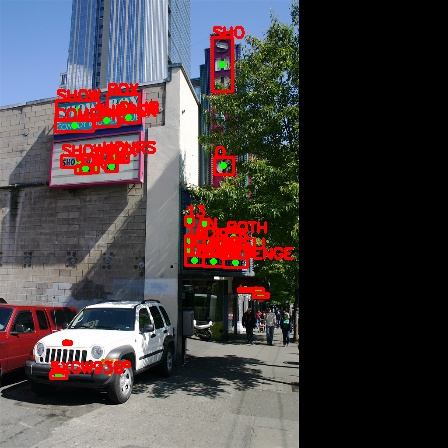

In [5]:
Image('img_with_annotations.jpg')

In [12]:
max_point_in_slice = 0
maxes = []
for img_idx in range(len(files)):
    slices = np.zeros((N, N), dtype=np.uint8)
    try:
        img_anns = bounding_boxes['imgToAnns'][img_ids[img_idx][:-4]]
    except KeyError:
        continue
    img = read_image(files[img_idx])
    img, ratio = pre_process_image(img)
    for i in range(len(img_anns)):
        ann = bounding_boxes['anns'][img_anns[i]]
        points = ann['bbox']
        x1, y1, x2, y2 = int(points[0]), int(points[1]), int(points[2]) + int(points[0]), int(points[3]) + int(points[1])
        x1, y1, x2, y2 = get_bbox_resized([x1, y1, x2, y2], ratio)
        middle_point = get_middle_point([x1, y1, x2, y2])
        x, y = int(middle_point[0] / slice_size), int(middle_point[1] / slice_size)
        if ann['utf8_string'] != '.':
            slices[x, y] += 1
    max_point_in_slice = max(max_point_in_slice, np.max(slices))
    maxes.append(np.max(slices))
    print(f'{img_idx}/{len(files)} max_point_in_slice: {max_point_in_slice} maxes avg: {np.mean(maxes)}', end='\r')
    break

print(max_point_in_slice)

2/25119 max_point_in_slice: 2 maxes avg: 2.0


In [13]:
idx_to_remove = []
for img_idx in range(len(files)):
    try:
        img_anns = bounding_boxes['imgToAnns'][img_ids[img_idx][:-4]]
    except KeyError:
        idx_to_remove.append(img_idx)
        continue

print('Number of images before removing images with no annotations: {}'.format(len(files)))
files = [i for j, i in enumerate(files) if j not in idx_to_remove]
img_ids = [i for j, i in enumerate(img_ids) if j not in idx_to_remove]
print('Number of images after removing images with no annotations: {}'.format(len(files)))

Number of images before removing images with no annotations: 25119
Number of images after removing images with no annotations: 21778


In [ ]:
from multiprocessing import Pool, Value, cpu_count

new_dir = 'proccessed_images_tensors'
# os.mkdir(new_dir)

# Initialize a shared counter to track progress
progress_counter = None

def init(counter):
    global progress_counter
    progress_counter = counter

def process_image_and_save(idx):
    img_path = files[idx]
    image = read_image(img_path)
    if image.shape[0] == 1:
        image = image.repeat(3, 1, 1)
    elif image.shape[0] != 3:
        image = image[:3]
    image, ratio = pre_process_image(image)
    torch.save(image, os.path.join(new_dir, img_ids[idx][:-4] + '.pt'))
    
    
    # Increment the progress counter
    with progress_counter.get_lock():
        progress_counter.value += 1
    
    # Print progress
    current_progress = progress_counter.value
    total_images = len(files)
    print(f'\rProcessing: {current_progress}/{total_images}', end='', flush=True)

if __name__ == '__main__':
    # Create a shared counter and initialize it to zero
    counter = Value('i', 0)
    print(cpu_count())
    with Pool(20, initializer=init, initargs=(counter,)) as p:
        # Map the function to the range of indices
        p.map(process_image_and_save, range(len(files)))
        
    # After completion, you can access the final progress count
    final_progress = counter.value
    print(f'\nProcessing completed: {final_progress}/{len(files)} images processed.')


In [14]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import random

class CustomImageDataset(Dataset):
    def __init__(self, N, slice_size, max_point_in_slice, files, new_size, img_ids):
        self.img_paths = files
        self.N = N
        self.slice_size = new_size // N
        self.max_point_in_slice = max_point_in_slice
        self.img_ids = img_ids


    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        # image = read_image(img_path)
        # if image.shape[0] == 1:
        #     image = image.repeat(3, 1, 1)
        # elif image.shape[0] != 3:
        #     image = image[:3]
        # image, ratio = pre_process_image(image)
        image = torch.load(os.path.join(new_dir, self.img_ids[:-4] + '.pt'))

        img_props = bounding_boxes['imgs'][img_ids[idx][:-4]]
        w, h = img_anns['width'], img_anns['height']
        max_shape = torch.max(w, h)
        ratio = new_size / max_shape

        slices = np.zeros((self.N*self.N, self.max_point_in_slice, 5))
        slices_counts = np.zeros((self.N*self.N, 1), dtype=np.int32)
        img_anns = bounding_boxes['imgToAnns'][self.img_ids[idx][:-4]]
        for i in range(len(img_anns)):
            ann = bounding_boxes['anns'][img_anns[i]]
            points = ann['bbox']
            x1, y1, x2, y2 = points[0], points[1], points[2] + points[0], points[3] + points[1]
            x1, y1, x2, y2 = get_bbox_resized([x1, y1, x2, y2], ratio)
            middle_point = get_middle_point([x1, y1, x2, y2])
            x_slice, y_slice = int(middle_point[0] / self.slice_size), int(middle_point[1] / self.slice_size)
            if ann['utf8_string'] != '.':
                if slices_counts[y_slice * self.N + x_slice] >= self.max_point_in_slice:
                    continue
                mid_x, mid_y = middle_point[0] - x_slice * self.slice_size, middle_point[1] - y_slice * self.slice_size
                mid_x, mid_y = mid_x / self.slice_size, mid_y / self.slice_size
                w, h = (x2 - x1) / self.slice_size, (y2 - y1) / self.slice_size
                slices[y_slice * self.N + x_slice][slices_counts[y_slice * self.N + x_slice]] = np.array([1, mid_x, mid_y, w, h])
                slices_counts[y_slice * self.N + x_slice] += 1
        label = slices
        image = image.float()
        label = torch.tensor(label)
        label = label.float()
        return image, label

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

files = np.array(files)
img_ids = np.array(img_ids)
rand_idxs = torch.randint(len(files), (int(0.1*len(files)),))
remaining_idxs = np.array([i for i in range(len(files)) if i not in rand_idxs])
val_files = files[rand_idxs]
val_img_ids = img_ids[rand_idxs]
train_files = files[remaining_idxs]
train_img_ids = img_ids[remaining_idxs]
max_point_in_slice = 9
batch_size = 32
train_dataset = CustomImageDataset(N, slice_size, max_point_in_slice, train_files, new_size, train_img_ids)
val_dataset = CustomImageDataset(N, slice_size, max_point_in_slice, val_files, new_size, val_img_ids)

train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=10,
                              pin_memory=True,
                              worker_init_fn=seed_worker,
                              generator=g)
test_dataloader = DataLoader(val_dataset,
                             batch_size=batch_size,
                             shuffle=True,
                             num_workers=10,
                             pin_memory=True,
                             worker_init_fn=seed_worker,
                             generator=g)
print(len(train_dataloader))
print(len(test_dataloader))

617
69


In [15]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
img = make_it_cv2(img) * 255
print(img.shape)
cv2.imwrite("test.jpg", img)
print(f"Label: {label}")
Image('test.jpg')

In [74]:
class YoloLoss_v1(nn.Module):
    def __init__(self):
        super(YoloLoss_v1, self).__init__()

    def forward(self, pred, target):
        # pred: (batch_size, N*N, max_points_in_slice, 5)
        # target: (batch_size, N*N, max_points_in_slice, 5)
        # mask: (batch_size, N*N, max_points_in_slice)
        mask = target[:, :, :, 0] > 0
        mask = mask.unsqueeze(-1).expand_as(target)
        pred = pred[mask].view(-1, 5)
        target = target[mask].view(-1, 5)
        loss = torch.nn.functional.mse_loss(pred, target, reduction='mean')
        return loss

class DarknetBlock(nn.Module):
    def __init__(self, start_size, num_of_layers):
        super(DarknetBlock, self).__init__()
        model = []
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.first_conv = nn.Conv2d(start_size, start_size*2, kernel_size=3, padding=1)
        for i in range(num_of_layers):
            model.append(nn.Conv2d(start_size*2, start_size, kernel_size=3, padding=1))
            model.append(nn.LeakyReLU(0.1, inplace=True))
            model.append(nn.Conv2d(start_size, start_size*2, kernel_size=1, padding=1))
            model.append(nn.LeakyReLU(0.1, inplace=True))
            model.append(nn.BatchNorm2d(start_size*2))

        self.model = nn.Sequential(nn.ModuleList(model))

    def forward(self, x):
        x = self.first_conv(x)
        x = self.max_pool(x)
        x_ = x
        for i in range(len(self.model) // 5):
            x = self.model[i*5](x)
            x = self.model[i*5+1](x)
            x = self.model[i*5+2](x)
            x = self.model[i*5+3](x)
            x = self.model[i*5+4](x)
            x = x + x_
            x_ = x
        return x


class Darknet19(nn.Module):
    def __init__(self, img_size, N, max_points_in_slice):
        super(Darknet19, self).__init__()
        self.img_size = img_size
        self.N = N
        self.max_points_in_slice = max_points_in_slice
        self.module_list = nn.ModuleList([
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),

            DarknetBlock(32, 1),

            DarknetBlock(64, 2),

            DarknetBlock(128, 8),

            DarknetBlock(256, 8),

            DarknetBlock(512, 4),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Conv2d(1024, self.max_points_in_slice*5, kernel_size=1, padding=0),
            nn.LeakyReLU(0.1, inplace=True)])
        self.model = nn.Sequential(
            *self.module_list
        )

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, self.N*self.N, self.max_points_in_slice, 5)
        return x

    def predict(self, x):
        x = self.forward(x)
        x[:, :, :, 0] = torch.sigmoid(x[:, :, :, 0])
        x[:, :, :, 1:3] = torch.sigmoid(x[:, :, :, 1:3])
        x[:, :, :, 3:5] = torch.exp(x[:, :, :, 3:5])
        return x



In [ ]:
class YoloLoss(nn.Module):
    def __init__(self):
        super(YoloLoss, self).__init__()

    def forward(self, inputs, targets):
        input_confidences = inputs[:, :, :, 0]
        target_confidences = targets[:, :, :, 0]
        detection_mask = target_confidences > 0.5
        no_object_mask = target_confidences <= 0.5

        divide_by = (inputs.size(0) * inputs.size(1) * inputs.size(2))

        # Confidence loss
        confidence_loss = torch.square(input_confidences[detection_mask] - target_confidences[detection_mask]).sum() / divide_by
        no_confidence_loss = torch.square(input_confidences[no_object_mask] - target_confidences[no_object_mask]).sum() / divide_by

        # Bounding box loss
        input_boxes = inputs[:, :, :, 1:3]
        target_boxes = targets[:, :, :, 1:3]
        target_boxes = -torch.log(1 / target_boxes - 1)
        box_loss = torch.square(input_boxes[detection_mask] - target_boxes[detection_mask]).sum() / divide_by
        
        # Size loss
        input_sizes = inputs[:, :, :, 3:5]
        target_sizes = targets[:, :, :, 3:5]
        target_sizes = torch.log(target_sizes)
        # input_sizes = torch.sqrt(input_sizes)
        # target_sizes = torch.sqrt(target_sizes)
        # print(input_sizes)
        # print(target_sizes)
        size_loss = torch.square(input_sizes[detection_mask] - target_sizes[detection_mask]).sum() / divide_by

        noob_gamma = 0.5
        cood_gamma = 5
        # print(no_confidence_loss)
        # print(confidence_loss)
        # print(box_loss)
        # print(size_loss)
        loss = noob_gamma * no_confidence_loss + confidence_loss + cood_gamma * (box_loss + size_loss)
        return loss

In [ ]:
def show_progress(epoch, step, total_steps, loss, width=30, bar_char='█', empty_char='░'):
    print('\r', end='')
    progress = ""
    for i in range(width):
        progress += bar_char if i < int(step / total_steps * width) else empty_char
    print(f"epoch:{epoch + 1} [{progress}] {step}/{total_steps} loss: {loss:.4f}", end='')
    if step >= total_steps - 1:
        print()


In [75]:
epochs = 50
def lr_lambda(epoch):
    max_epochs = epochs
    return (1 - epoch / max_epochs) ** 4
torch.cuda.empty_cache()
model = Darknet19(new_size, N, max_point_in_slice)
model.to(device)
loss = YoloLoss_v1()
# starting learning rate of 0.1, polynomial rate decay with a power of 4, weight decay of 0.0005 and momentum of 0.9.
optimizer = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9, weight_decay=0.00)
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
model.train()
for epoch in range(epochs):
    for i, (x, y) in enumerate(train_dataloader):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.autocast('cuda'):
            output = model.forward(x)
            loss_val = loss(output, y)
        loss_val.backward()
        optimizer.step()
        # scheduler.step()
        x.detach()
        y.detach()
        with torch.no_grad():
            if i == 0:
              loss_arr = []
            loss_arr.append(loss_val.item())
            show_progress(epoch, i, len(train_dataloader), np.mean(loss_arr))


# validation
model.eval()
total_val_loss = 0.0
with torch.no_grad():
    for i, (x, y) in enumerate(test_dataloader):
        x = x.to(device)
        y = y.to(device)
        output = model.forward(x)
        loss_val = loss(output, y)
        x.detach()
        y.detach()
        total_val_loss += loss_val.item()
    average_val_loss = total_val_loss / len(test_dataloader)

print(f'Validation Loss: {average_val_loss}')

In [ ]:
test_features, test_labels = next(iter(test_dataloader))
test_features = test_features.to(device)
predictions = model.forward(test_features)
predictions = predictions.to(device)
idx = 0

In [ ]:
prediction = predictions[idx]
print(prediction)
print(test_labels[idx])
prediction = prediction.view(N, N, max_point_in_slice*5)
test_features = test_features.cpu()
img = make_it_cv2(test_features[idx]) * 255
bounding_boxes = []
for i in range(N):
    for j in range(N):
        for k in range(max_point_in_slice):
            if prediction[i][j][k*5] > 0.3:
                w = prediction[i][j][k*5+3]*slice_size
                h = prediction[i][j][k*5+4]*slice_size
                x = prediction[i][j][k*5+1]*slice_size + j*slice_size - w/2
                y = prediction[i][j][k*5+2]*slice_size + i*slice_size - h/2
                x1, y1, x2, y2 = int(x), int(y), int(x+w), int(y+h)
                bounding_boxes.append([x1, y1, x2, y2])

for box in bounding_boxes:
    x1, y1, x2, y2 = box
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
idx += 1
cv2.imwrite('test.jpg', img)
Image('test.jpg')